# Prototype 6 - Custom 1 + Keras dataset loader

## 1. Determine the absolute path of the dataset based on a provided relative path

In [4]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Get the absolute path of the dataset
dataset_dir = os.path.abspath('../datasets/FINAL DATASET')
# dataset_dir = "C:\\Users\\rektplorer64\\OneDrive\\Pictures\\Wallpapers"

class_names = list(filter(lambda x: ".py" not in x, os.listdir(dataset_dir)))

print('There are', len(class_names), 'classes as follows:')
print(class_names)


There are 38 classes as follows:
['stewed_pork_leg', 'caesar_salad', 'noodles_without_soup', 'coconut_milk_soup', 'kebab', 'hot_and_sour_fish_and_vegetable_ragout', 'steak_with_rice', 'chow_mein', 'noodles_with_fish_curry', 'pizza', 'crispy_pork_with_kale_with_rice', 'yellow_curry', 'rice_crispy_pork', 'rice_topped_with_stir_fried_meat_and_basil', 'omelette', 'steamed_chicken_with_rice', 'spring_rolls', 'pad_see_ew', 'spicy_stir_fried_pork_with_red_curry_paste', 'spaghetti_bolognese', 'barbecued_red_pork_in_sauce_with_rice', 'fried_rice', 'pad_thai', 'hamburger', 'onion_rings', 'khao_soi', 'fried_chicken_with_rice', 'green_curry', 'spicy_chicken_salad_with_rice', 'spaghetti_carbonara', 'peking_duck', 'steamed_rice_roll', 'fried_pork_with_rice', 'steak', 'charcoal-boiled_pork_neck', 'noodles', 'thai_papaya_salad', 'fried_mussel_pancakes']


In [5]:
model_name = "prototype6-custom1"

# Configure these hyper-params
batch_size = 32
image_size = (256, 256)
random_seed = 12312312

In [6]:
def crop_center(image):
    
#     print(image.get_shape())
    h, w = image.shape[-3], image.shape[-2]

    if h > w:
        cropped_image = tf.image.crop_to_bounding_box(image, (h - w) // 2, 0, w, w)
    else:
        cropped_image = tf.image.crop_to_bounding_box(image, 0, (w - h) // 2, h, h)
    return tf.image.resize_images(cropped_image, image_size)

def decode_img(img, img_size):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  
  # resize the image to the desired size
  img = tf.image.resize(img, [img_size[0], img_size[1]])
  return img

def process_path(file_path, class_names, img_size):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img, img_size)
  return img


def map_load_image(file_path, label):
#     print(file_path, label)
    final_one_hot_label = label == class_names
    return process_path(file_path, class_names, image_size), tf.argmax(final_one_hot_label)

In [7]:
import tensorflow as tf

from tensorflow.data import Dataset
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

from keras.preprocessing.image import ImageDataGenerator

import numpy as np
from sklearn.model_selection import train_test_split

from extract_label_from_url import extract_label_from_url

import glob
import random


#  -----------------------------------------------------------------------------
# Take a look at each folder to get its files' url
image_filepath_list = glob.glob(dataset_dir + '/*/*')

# Image Count => count its length
image_count = len(image_filepath_list)
print('There are', image_count, 'images in the dataset.')

# Infer label from each url
image_dataset_labels = list(map(lambda x: extract_label_from_url(x), image_filepath_list))
# print(image_dataset_labels)

#  -----------------------------------------------------------------------------
# Split for [Training + Validation] set & [Testing] set
X_train_val, X_test, y_train_val, y_test = train_test_split(image_filepath_list, image_dataset_labels, test_size=0.2, random_state=1, stratify=image_dataset_labels)

# Split again for [Training] set & [Testing] set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1, stratify=y_train_val) # 0.25 x 0.8 = 0.2

# Show dataset splits summary
print('Training Set\tsize:\t', len(X_train), '\tlabel:',len(y_train))
print('Validation Set\tsize:\t', len(X_val), '\tlabel:',len(y_val))
print('Testing Set\tsize:\t', len(X_test), '\tlabel:',len(y_test))
print('Total Dataset\tsize:\t', len(X_train) + len(X_val) + len(X_test))

# List 5 sample files
print('\n\nSample 5 images -------------------')
for f in random.sample(image_filepath_list, 5):
  print(extract_label_from_url(f), '\n', f, '\n')

# FORM TENSORFLOW DATASETS: https://www.tensorflow.org/api_docs/python/tf/data/Dataset?version=nightly#from_tensor_slices
#  -----------------------------------------------------------------------------


# STEP 1: Training set formation
dataset_train_X = Dataset.from_tensor_slices(X_train)
dataset_train_Y = Dataset.from_tensor_slices(y_train)
dataset_train = Dataset.zip((dataset_train_X, dataset_train_Y))

# STEP 2: Validation set formation
dataset_val_X = Dataset.from_tensor_slices(X_val)
dataset_val_Y = Dataset.from_tensor_slices(y_val)
dataset_val = Dataset.zip((dataset_val_X, dataset_val_Y))

# STEP 3: Testing set formation
dataset_test_X = Dataset.from_tensor_slices(X_test)
dataset_test_Y = Dataset.from_tensor_slices(y_test)
dataset_test = Dataset.zip((dataset_test_X, dataset_test_Y))

# STEP 4: Covert tensor slices of (image url, label) to actual image that will be loaded later
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.

AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = dataset_train.map(map_load_image, num_parallel_calls=AUTOTUNE).batch(batch_size)
ds_val = dataset_val.map(map_load_image, num_parallel_calls=AUTOTUNE).batch(batch_size)
ds_test = dataset_test.map(map_load_image, num_parallel_calls=AUTOTUNE).batch(batch_size)

print("\n\nDatastore Metadata ----------------------")
for image, label in ds_train.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
for image_batch, labels_batch in ds_train:
    image_size_with_color = image_batch[0].shape
    print("\nThe DIMENSION OF One Batch of images", image_batch.shape)
    print("The Batches size", labels_batch.shape)
    break

There are 9500 images in the dataset.
Training Set	size:	 5700 	label: 5700
Validation Set	size:	 1900 	label: 1900
Testing Set	size:	 1900 	label: 1900
Total Dataset	size:	 9500


Sample 5 images -------------------
thai_papaya_salad 
 /home/psimilan/psimilan-notebooks/pooh/ITCS402-PJ_Thai_Food_Image_Recognition/datasets/FINAL DATASET/thai_papaya_salad/images59.jpg 

charcoal-boiled_pork_neck 
 /home/psimilan/psimilan-notebooks/pooh/ITCS402-PJ_Thai_Food_Image_Recognition/datasets/FINAL DATASET/charcoal-boiled_pork_neck/charcoal-boiled_pork_neck-RandThaiFood-i-014.jpg 

hamburger 
 /home/psimilan/psimilan-notebooks/pooh/ITCS402-PJ_Thai_Food_Image_Recognition/datasets/FINAL DATASET/hamburger/hamburger-ThaiFoodDataset-117.jpg 

spicy_chicken_salad_with_rice 
 /home/psimilan/psimilan-notebooks/pooh/ITCS402-PJ_Thai_Food_Image_Recognition/datasets/FINAL DATASET/spicy_chicken_salad_with_rice/spicy_chicken_salad_with_rice-RandThaiFood-i-051.jpg 

noodles 
 /home/psimilan/psimilan-notebooks/po

## * Show some images in the dataset

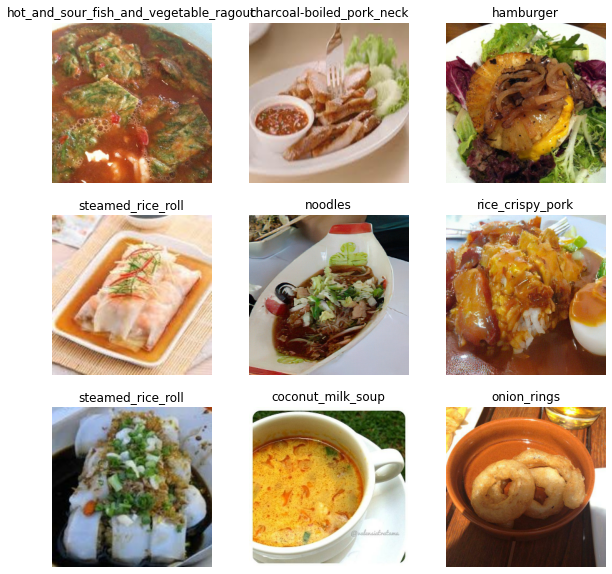

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
#     print(labels)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
       
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

## ⭐ Define the Model
Here we specify the composition of the neural network.

In [25]:
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop, Rescaling, RandomFlip, RandomRotation, RandomZoom

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, LeakyReLU, Activation
from keras.layers.normalization import BatchNormalization
import tensorflow_addons as tfa
import visualkeras

model = Sequential()

## Input Layer
model.add(keras.Input(shape=image_size_with_color))

## Input Preprocessing Layers: https://www.tensorflow.org/guide/keras/preprocessing_layers
data_augmentation = keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomFlip("vertical"),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ], "preprocessing"
)
model.add(data_augmentation)
model.add(Rescaling(scale=1.0/255.0))


model.add(Conv2D(96, 9, input_shape=image_size_with_color, padding="same",  activation='relu'))

# Add spacing to the following visualization
model.add(visualkeras.SpacingDummyLayer(spacing=20))

model.add(Conv2D(96, 9))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Add spacing to the following visualization
model.add(visualkeras.SpacingDummyLayer(spacing=20))

model.add(Conv2D(96, 9, kernel_regularizer=tf.keras.regularizers.l2(l=0.02)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Add spacing to the following visualization
model.add(visualkeras.SpacingDummyLayer(spacing=20))

model.add(MaxPooling2D((2, 2), name="pool1"))
model.add(Dropout(0.3))

# ------------------------- Add spacing to the following visualization -------------------------
model.add(visualkeras.SpacingDummyLayer(spacing=20))

model.add(Conv2D(64, 5, kernel_regularizer =tf.keras.regularizers.l2(l=0.02)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

# Add spacing to the following visualization
model.add(visualkeras.SpacingDummyLayer(spacing=20))

model.add(Conv2D(64, 5))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.4))

# Add spacing to the following visualization
model.add(visualkeras.SpacingDummyLayer(spacing=20))

model.add(Conv2D(64, 4))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.4))
# model.add(Conv2D(72, 4))
# model.add(LeakyReLU())
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(124, 4, kernel_regularizer=tf.keras.regularizers.l2(l=0.02)))
# model.add(LeakyReLU())
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(128, 3, activation='relu'))

model.add(GlobalAveragePooling2D())

# Add spacing to the following visualization
model.add(visualkeras.SpacingDummyLayer(spacing=20))

model.add(Dense(124, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(len(class_names), activation = 'softmax'))


opt = keras.optimizers.Adam(learning_rate=0.00001)
final_opt = tfa.optimizers.MovingAverage(opt)

model.compile(loss='sparse_categorical_crossentropy', optimizer=final_opt, metrics=["accuracy"])
model.summary()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing (Sequential)   (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 256, 256, 96)      23424     
_________________________________________________________________
spacing_dummy_layer_8 (Spaci (None, 256, 256, 96)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 248, 248, 96)      746592    
_________________________________________________________________
batch_normalization_25 (Batc (None, 248, 248, 96)      384       
_________________________________________________________________
activation_25 (Activation)   (None, 248, 248, 96)     

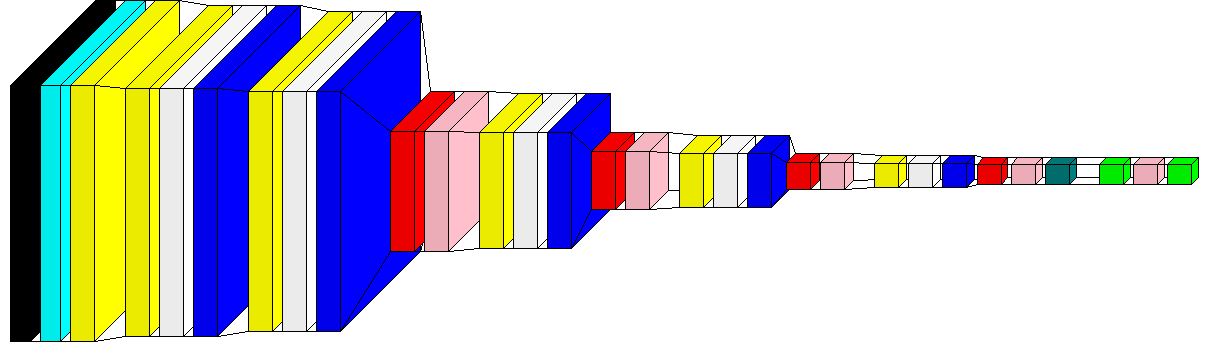

In [62]:
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from collections import defaultdict

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'yellow'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'lime'
color_map[GlobalAveragePooling2D]['fill'] = 'teal'
color_map[BatchNormalization]['fill'] = 'white'
color_map[Rescaling]['fill'] = 'cyan'
color_map[Sequential]['fill'] = 'black'
color_map[Activation]['fill'] = 'blue'

# visualkeras.layered_view(model, color_map=color_map)


visualkeras.layered_view(model, 
                         color_map=color_map, to_file=model_name + '.png', 
                         scale_xy=1, scale_z=1, max_z=24, 
#                          type_ignore=[Activation, Dropout, BatchNormalization, Rescaling, Sequential]
                        )

In [7]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

# early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')
# reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto', min_lr=0.00001)
model_training_history = model.fit(ds_train,
#         steps_per_epoch=int(np.ceil(len(X_train) / batch_size)),
        epochs=350,
        validation_data=ds_val,
#         validation_steps=int(np.ceil(len(X_val)  / batch_size)),
        verbose=1 
          ,callbacks=[
#               early, 
              tfdocs.modeling.EpochDots()
#               reduce
          ]
         )

Epoch 1/350
179/179 [==============================] - ETA: 0s - loss: 7.2384 - accuracy: 0.0326
Epoch: 0, accuracy:0.0326,  loss:7.2384,  val_accuracy:0.0263,  val_loss:6.9588,  
179/179 [==============================] - 149s 833ms/step - loss: 7.2384 - accuracy: 0.0326 - val_loss: 6.9588 - val_accuracy: 0.0263
Epoch 2/350
179/179 [==============================] - 148s 824ms/step - loss: 6.8746 - accuracy: 0.0460 - val_loss: 6.7492 - val_accuracy: 0.0284
Epoch 3/350
179/179 [==============================] - 147s 823ms/step - loss: 6.5906 - accuracy: 0.0551 - val_loss: 6.4961 - val_accuracy: 0.0442
Epoch 4/350
179/179 [==============================] - 147s 823ms/step - loss: 6.3297 - accuracy: 0.0581 - val_loss: 6.2360 - val_accuracy: 0.0637
Epoch 5/350
179/179 [==============================] - 147s 823ms/step - loss: 6.0894 - accuracy: 0.0689 - val_loss: 6.0114 - val_accuracy: 0.0768
Epoch 6/350
179/179 [==============================] - 147s 823ms/step - loss: 5.8710 - accuracy:

179/179 [==============================] - 147s 823ms/step - loss: 2.2859 - accuracy: 0.4095 - val_loss: 2.8777 - val_accuracy: 0.3332
Epoch 108/350
179/179 [==============================] - 147s 823ms/step - loss: 2.3000 - accuracy: 0.4072 - val_loss: 2.8651 - val_accuracy: 0.3300
Epoch 109/350
179/179 [==============================] - 147s 824ms/step - loss: 2.2896 - accuracy: 0.4105 - val_loss: 2.8402 - val_accuracy: 0.3668
Epoch 110/350
179/179 [==============================] - 147s 824ms/step - loss: 2.2898 - accuracy: 0.4032 - val_loss: 2.8284 - val_accuracy: 0.3716
Epoch 111/350
179/179 [==============================] - 147s 824ms/step - loss: 2.2667 - accuracy: 0.4189 - val_loss: 2.8266 - val_accuracy: 0.3658
Epoch 112/350
179/179 [==============================] - 147s 823ms/step - loss: 2.2570 - accuracy: 0.4102 - val_loss: 2.8245 - val_accuracy: 0.3521
Epoch 113/350
179/179 [==============================] - 147s 824ms/step - loss: 2.2448 - accuracy: 0.4132 - val_loss: 2

179/179 [==============================] - 148s 826ms/step - loss: 1.6185 - accuracy: 0.5649 - val_loss: 2.3412 - val_accuracy: 0.4332
Epoch 211/350
179/179 [==============================] - 148s 827ms/step - loss: 1.6082 - accuracy: 0.5649 - val_loss: 2.2358 - val_accuracy: 0.4558
Epoch 212/350
179/179 [==============================] - 148s 828ms/step - loss: 1.5932 - accuracy: 0.5654 - val_loss: 2.4261 - val_accuracy: 0.3884
Epoch 213/350
179/179 [==============================] - 148s 827ms/step - loss: 1.5959 - accuracy: 0.5633 - val_loss: 2.3221 - val_accuracy: 0.4532
Epoch 214/350
179/179 [==============================] - 148s 827ms/step - loss: 1.5936 - accuracy: 0.5735 - val_loss: 2.3497 - val_accuracy: 0.4111
Epoch 215/350
179/179 [==============================] - 148s 828ms/step - loss: 1.6056 - accuracy: 0.5668 - val_loss: 2.3515 - val_accuracy: 0.4142
Epoch 216/350
179/179 [==============================] - 148s 828ms/step - loss: 1.5923 - accuracy: 0.5540 - val_loss: 2

179/179 [==============================] - 148s 826ms/step - loss: 1.4159 - accuracy: 0.6075 - val_loss: 2.1715 - val_accuracy: 0.4600
Epoch 267/350
179/179 [==============================] - 147s 824ms/step - loss: 1.3927 - accuracy: 0.6146 - val_loss: 2.0296 - val_accuracy: 0.5016
Epoch 268/350
179/179 [==============================] - 147s 823ms/step - loss: 1.3930 - accuracy: 0.6146 - val_loss: 2.2057 - val_accuracy: 0.4295
Epoch 269/350
179/179 [==============================] - 148s 828ms/step - loss: 1.3960 - accuracy: 0.6193 - val_loss: 2.1479 - val_accuracy: 0.4500
Epoch 270/350
179/179 [==============================] - 148s 829ms/step - loss: 1.3766 - accuracy: 0.6186 - val_loss: 2.1663 - val_accuracy: 0.4532
Epoch 271/350
179/179 [==============================] - 148s 829ms/step - loss: 1.3711 - accuracy: 0.6246 - val_loss: 2.2131 - val_accuracy: 0.4405
Epoch 272/350
179/179 [==============================] - 148s 829ms/step - loss: 1.3793 - accuracy: 0.6295 - val_loss: 2

Epoch 322/350
179/179 [==============================] - 148s 825ms/step - loss: 1.2393 - accuracy: 0.6626 - val_loss: 2.1085 - val_accuracy: 0.4574
Epoch 323/350
179/179 [==============================] - 148s 828ms/step - loss: 1.2334 - accuracy: 0.6582 - val_loss: 2.2093 - val_accuracy: 0.3942
Epoch 324/350
179/179 [==============================] - 148s 829ms/step - loss: 1.2232 - accuracy: 0.6661 - val_loss: 2.1506 - val_accuracy: 0.4447
Epoch 325/350
179/179 [==============================] - 148s 828ms/step - loss: 1.2157 - accuracy: 0.6677 - val_loss: 2.0748 - val_accuracy: 0.4726
Epoch 326/350
179/179 [==============================] - 148s 828ms/step - loss: 1.2137 - accuracy: 0.6726 - val_loss: 2.0115 - val_accuracy: 0.4689
Epoch 327/350
179/179 [==============================] - 148s 828ms/step - loss: 1.2198 - accuracy: 0.6644 - val_loss: 2.2162 - val_accuracy: 0.4068
Epoch 328/350
179/179 [==============================] - 148s 829ms/step - loss: 1.2217 - accuracy: 0.6633

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### Save the trained weights

In [8]:
!mkdir -p saved_model
model.save('saved_model/' + model_name)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/prototype6-custom1/assets


### 💾 Save the Training History into a csv file

In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(model_training_history.history) 

# # save to json:  
# hist_json_file = 'history.json' 
# with open(hist_json_file, mode='w') as f:
#     hist_df.to_json(f)

# or save to csv: 
!mkdir -p training_history
hist_csv_file = './training_history/' + model_name + '_training-history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# ✅ Evaluation
### 👁 Plot the Loss and Accuracy during Training

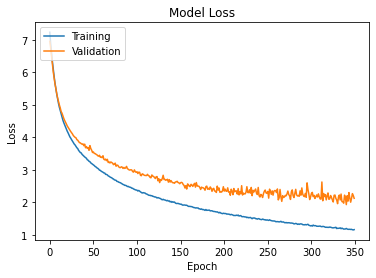

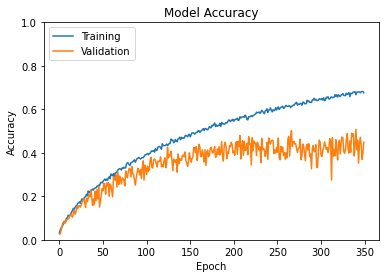

In [ ]:
# !pip install -q git+https://github.com/tensorflow/docs

# summarize history for loss
fig = plt.figure()
ax = plt.gca()
ax.plot(model_training_history.history['loss'], label='Training')
ax.plot(model_training_history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
ax.legend(loc='upper left')
plt.show()

# summarize history for accuracy
fig = plt.figure()
ax2 = plt.gca()
ax2.plot(model_training_history.history['accuracy'], label='Training')
ax2.plot(model_training_history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
ax2.legend(loc='upper left')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

predictions = np.array([])
true_labels = np.array([])
print(images.shape)

count = 0
for image, true_label in ds_test:
    prediction = np.argmax(model.predict(image), axis=1)
    
    predictions = np.append(predictions, prediction)
    true_labels = np.append(true_labels, true_label)

print(images.shape, true_labels.shape)

print("Prediction", predictions.shape, predictions)

confusion_matrix = confusion_matrix(predictions, true_labels)
print("\nConfusion Matrix ---------------------------\n", confusion_matrix)

# evaluation = model.evaluate(X_test, y_test, 20)
print(type(confusion_matrix))

(32, 256, 256, 3)
(32, 256, 256, 3) (1900,)
Prediction (1900,) [ 0.  2. 19. ...  6. 36.  8.]

Confusion Matrix ---------------------------
 [[21  0  0 ...  0  1  0]
 [ 3 45  0 ...  0  4  0]
 [ 0  0 37 ... 12  0  0]
 ...
 [ 0  0  0 ... 12  0  0]
 [ 0  0  0 ...  0 18  1]
 [ 3  0  0 ...  0  3 34]]
<class 'numpy.ndarray'>


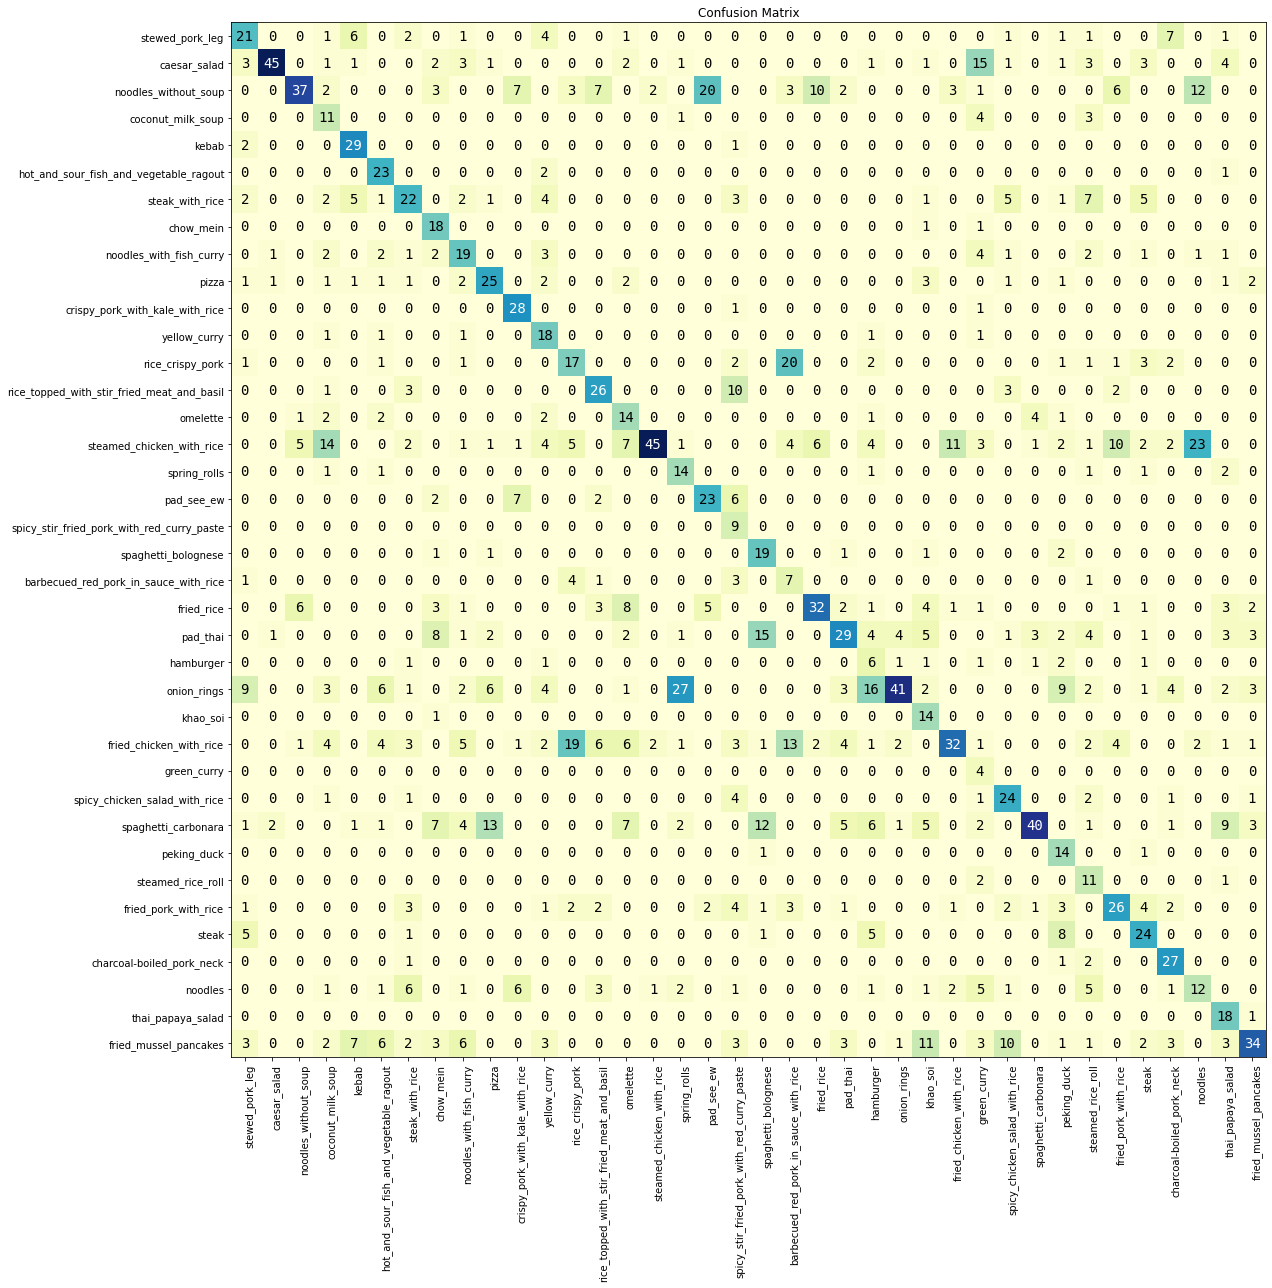

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 18)

im = ax.imshow(confusion_matrix, cmap="YlGnBu")

# We want to show all ticks...
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        color = 'k'
        if confusion_matrix[i, j] > 25:
            color = 'w'
        
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color=color, fontfamily="monospace", fontsize=14)

ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Report Util: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
print(classification_report(predictions, true_labels, target_names=class_names))

                                            precision    recall  f1-score   support

                           stewed_pork_leg       0.42      0.45      0.43        47
                              caesar_salad       0.90      0.51      0.65        88
                      noodles_without_soup       0.74      0.31      0.44       118
                         coconut_milk_soup       0.22      0.58      0.32        19
                                     kebab       0.58      0.91      0.71        32
    hot_and_sour_fish_and_vegetable_ragout       0.46      0.88      0.61        26
                           steak_with_rice       0.44      0.36      0.40        61
                                 chow_mein       0.36      0.90      0.51        20
                   noodles_with_fish_curry       0.38      0.47      0.42        40
                                     pizza       0.50      0.56      0.53        45
           crispy_pork_with_kale_with_rice       0.56      0.93      0.70  

In [ ]:
import collections
counter=collections.Counter(y_test)
print(counter)

Counter({'charcoal-boiled_pork_neck': 50, 'pad_see_ew': 50, 'spaghetti_bolognese': 50, 'fried_chicken_with_rice': 50, 'crispy_pork_with_kale_with_rice': 50, 'steamed_chicken_with_rice': 50, 'thai_papaya_salad': 50, 'kebab': 50, 'noodles': 50, 'hot_and_sour_fish_and_vegetable_ragout': 50, 'hamburger': 50, 'caesar_salad': 50, 'rice_crispy_pork': 50, 'spring_rolls': 50, 'spicy_stir_fried_pork_with_red_curry_paste': 50, 'yellow_curry': 50, 'omelette': 50, 'coconut_milk_soup': 50, 'steamed_rice_roll': 50, 'peking_duck': 50, 'barbecued_red_pork_in_sauce_with_rice': 50, 'spicy_chicken_salad_with_rice': 50, 'khao_soi': 50, 'noodles_without_soup': 50, 'spaghetti_carbonara': 50, 'fried_pork_with_rice': 50, 'steak_with_rice': 50, 'noodles_with_fish_curry': 50, 'steak': 50, 'pizza': 50, 'onion_rings': 50, 'pad_thai': 50, 'chow_mein': 50, 'green_curry': 50, 'fried_mussel_pancakes': 50, 'stewed_pork_leg': 50, 'rice_topped_with_stir_fried_meat_and_basil': 50, 'fried_rice': 50})
